In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings("ignore")

# **Data Cleaning**

In [17]:
# read csv data
df = pd.read_csv(r'https://media.githubusercontent.com/media/conguflama/Citadel-Summer-Datathon/main/data/cleaned_dataset/cleaned_dataset_monthly.csv')

In [18]:
google_index = pd.read_csv('https://media.githubusercontent.com/media/conguflama/Citadel-Summer-Datathon/main/data/goole%20index%26estab/google_index.csv')
google_index = google_index.iloc[:, 1:]
google_index

,month,airbnb
0,2009-01,0
1,2009-02,0
2,2009-03,0
3,2009-04,0
4,2009-05,0
...,...,...
127,2019-08,91
128,2019-09,77
129,2019-10,74
130,2019-11,69


In [19]:
estab = pd.read_csv('https://media.githubusercontent.com/media/conguflama/Citadel-Summer-Datathon/main/data/goole%20index%26estab/09_estab.csv')
estab = estab.iloc[:, 1:]
estab

,MSA,Establishment
0,Austin,40281
1,Asheville,11639
2,Los Angeles,333006
3,Nashville,37883
4,New Orleans,29100


In [20]:
occupancy_rate = pd.read_csv('https://media.githubusercontent.com/media/conguflama/Citadel-Summer-Datathon/main/data/occupancy_rate/occupancy.csv')
occupancy_rate

,city,occupancy_rate
0,Asheville,0.904
1,Austin,0.922
2,Los Angeles,0.933
3,Nashville,0.901
4,New Orleans,0.725


In [21]:
df.head()

,Unnamed: 0,Year_month,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education
0,0,2009-12,Asheville,0.0,22222.0,14418.294867,34399.972097,414.327117,7.4,213247.0,31.2
1,1,2009-12,Austin,4.5,329526.0,91270.989639,42465.021267,1697.808073,6.4,238387.0,17.9
2,2,2009-12,Los Angeles,6.0,2334939.0,748862.573044,44175.589140,12926.602218,13.4,444590.0,29.0
3,3,2009-12,Nashville,1.0,343003.0,86302.900181,42337.457466,1599.243444,9.0,177900.0,34.0
4,4,2009-12,New Orleans,0.0,315363.0,66172.813637,39846.759729,1242.308644,7.6,151936.0,31.6


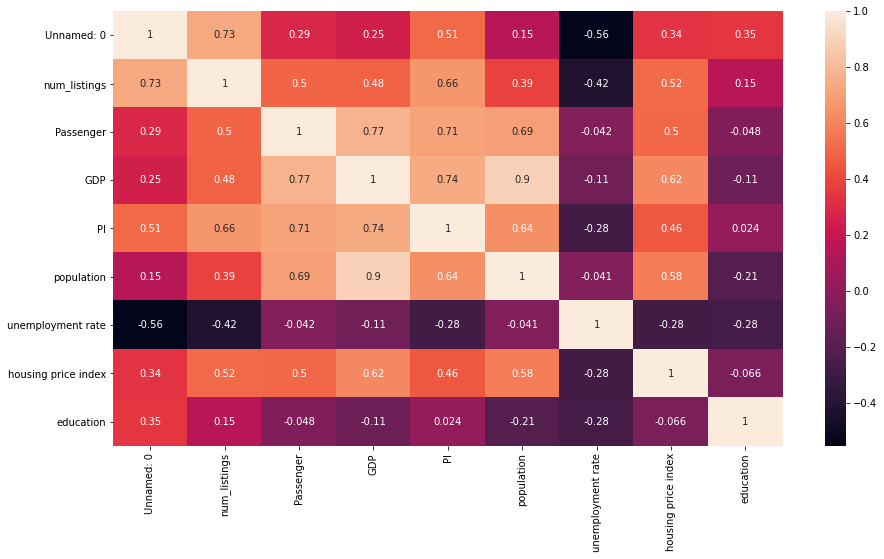

In [22]:
import seaborn as sns
corr = df.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)

In [23]:
# one-hot city column
df = df.iloc[:,1:].join(pd.get_dummies(df.city))

In [24]:
# one-hot date column by year
df['Year_month'] = df['Year_month'].map(lambda x: x.split('-')[0])
df = df.iloc[:,1:].join(pd.get_dummies(df.Year_month))
df

,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,Asheville,Austin,Los Angeles,Nashville,New Orleans,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Asheville,0.00,22222.0,1.441829e+04,34399.972097,414.327117,7.4,213247.0,31.2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Austin,4.50,329526.0,9.127099e+04,42465.021267,1697.808073,6.4,238387.0,17.9,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Los Angeles,6.00,2334939.0,7.488626e+05,44175.589140,12926.602218,13.4,444590.0,29.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Nashville,1.00,343003.0,8.630290e+04,42337.457466,1599.243444,9.0,177900.0,34.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,New Orleans,0.00,315363.0,6.617281e+04,39846.759729,1242.308644,7.6,151936.0,31.6,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Asheville,1441.50,69394.0,1.993445e+04,43046.807353,464.855148,2.6,297489.0,40.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
596,Austin,3429.50,703163.0,1.470664e+05,53558.440882,2207.648209,2.4,399216.0,23.9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
597,Los Angeles,11339.00,3242638.0,1.031996e+06,55398.495294,13244.111888,4.3,723837.0,32.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
598,Nashville,3139.25,726092.0,1.307348e+05,53441.159902,1934.070099,2.4,292210.0,41.7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [25]:
# log selected columns
to_log_columns = ['num_listings','Passenger','GDP','PI','population', \
                  'housing price index']
for column in to_log_columns:
  df[column] = np.log(df[column]+1)
df.head()

,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,Asheville,Austin,Los Angeles,Nashville,New Orleans,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Asheville,0.000000,10.008883,9.576323,10.445840,6.029066,7.4,12.270211,31.2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Austin,1.704748,12.705414,11.421599,10.656460,7.437682,6.4,12.381655,17.9,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Los Angeles,1.945910,14.663497,13.526312,10.695950,9.467120,13.4,13.004910,29.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Nashville,0.693147,12.745497,11.365630,10.653451,7.377911,9.0,12.088982,34.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,New Orleans,0.000000,12.661483,11.100040,10.592821,7.125531,7.6,11.931221,31.6,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


In [26]:
df = pd.merge(df, occupancy_rate, on =['city'])
df['listing x occupancy'] = df['num_listings'] * df['occupancy_rate']
df.head()

,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,Asheville,Austin,Los Angeles,Nashville,New Orleans,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,occupancy_rate,listing x occupancy
0,Asheville,0.0,10.008883,9.576323,10.445840,6.029066,7.4,12.270211,31.2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.904,0.0
1,Asheville,0.0,9.743495,9.579532,10.447950,6.030088,8.0,12.260727,31.2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.904,0.0
2,Asheville,0.0,9.793561,9.582731,10.450056,6.031109,7.9,12.247771,31.2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.904,0.0
3,Asheville,0.0,10.154596,9.585921,10.452157,6.032129,7.7,12.233576,31.2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.904,0.0
4,Asheville,0.0,10.297892,9.589099,10.454253,6.033147,7.0,12.229882,31.2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.904,0.0


# **Part 1. Linear Regression**

In [27]:
# No Fixed Effects - With LA.
y = df['housing price index']
X = df['num_listings']
result = sm.OLS(y, X).fit(cov_type='HC1')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     housing price index   R-squared (uncentered):                   0.841
Model:                             OLS   Adj. R-squared (uncentered):              0.841
Method:                  Least Squares   F-statistic:                              9441.
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):                        0.00
Time:                         15:41:59   Log-Likelihood:                         -1815.2
No. Observations:                  600   AIC:                                      3632.
Df Residuals:                      599   BIC:                                      3637.
Df Model:                            1                                                  
Covariance Type:                   HC1                                                  
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
num_listings     1.9607      0.020     97.165      0.000       1.921       2.000
==============================================================================
Omnibus:                       55.679   Durbin-Watson:                   0.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.583
Skew:                           0.577   Prob(JB):                     2.08e-10
Kurtosis:                       2.327   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [28]:
fig = sm.graphics.plot_regress_exog(result, "num_listings")
fig.set_size_inches(20, 12)
fig.tight_layout(pad=0.1,h_pad = 5, w_pad = 25)

In [29]:
# No Fixed Effects - With LA.
y = df['housing price index']
X = sm.add_constant(df[['num_listings','listing x occupancy','GDP','PI','population',\
                        'unemployment rate']])
result = sm.OLS(y, X).fit(cov_type='HC1')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     housing price index   R-squared:                       0.951
Model:                             OLS   Adj. R-squared:                  0.950
Method:                  Least Squares   F-statistic:                     2924.
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:41:59   Log-Likelihood:                 562.70
No. Observations:                  600   AIC:                            -1111.
Df Residuals:                      593   BIC:                            -1081.
Df Model:                            6                                         
Covariance Type:                   HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.3521      2.256      2.372      0.018       0.930       9.774
num_listings            0.0787      0.015      5.229      0.000       0.049       0.108
listing x occupancy    -0.0216      0.022     -0.976      0.329      -0.065       0.022
GDP                    -2.3005      0.147    -15.676      0.000      -2.588      -2.013
PI                      1.1370      0.256      4.447      0.000       0.636       1.638
population              2.8590      0.162     17.638      0.000       2.541       3.177
unemployment rate      -0.0522      0.005    -10.847      0.000      -0.062      -0.043
==============================================================================
Omnibus:                       26.370   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.481
Skew:                          -0.024   Prob(JB):                      0.00321
Kurtosis:                       2.324   Cond. No.                     1.19e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# No Fixed Effects simple OLS - without LA.
df_no_la = df.loc[df['city'] != 'Los Angeles']
y = df_no_la['housing price index']
X = sm.add_constant(df_no_la[['num_listings','listing x occupancy','GDP','PI','population',\
                        'unemployment rate']])
result = sm.OLS(y, X).fit(cov_type='HC1')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     housing price index   R-squared:                       0.871
Model:                             OLS   Adj. R-squared:                  0.869
Method:                  Least Squares   F-statistic:                     651.2
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):          5.63e-225
Time:                         15:41:59   Log-Likelihood:                 472.65
No. Observations:                  480   AIC:                            -931.3
Df Residuals:                      473   BIC:                            -902.1
Df Model:                            6                                         
Covariance Type:                   HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.3226      3.375      0.392      0.695      -5.291       7.937
num_listings            0.2034      0.037      5.512      0.000       0.131       0.276
listing x occupancy    -0.1157      0.041     -2.811      0.005      -0.196      -0.035
GDP                    -4.0551      0.448     -9.047      0.000      -4.934      -3.177
PI                      1.8482      0.418      4.418      0.000       1.028       2.668
population              5.0373      0.533      9.455      0.000       3.993       6.081
unemployment rate      -0.0109      0.008     -1.352      0.176      -0.027       0.005
==============================================================================
Omnibus:                       14.226   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               12.936
Skew:                           0.344   Prob(JB):                      0.00155
Kurtosis:                       2.584   Cond. No.                     1.24e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
# run OLS model - WITH LA
y = df['housing price index']
X = sm.add_constant(df[['num_listings','listing x occupancy','GDP','PI','population',\
                        'unemployment rate','Asheville','Los Angeles','Austin','Nashville', \
                        '2009', '2010', '2011', '2012', '2013', '2014', '2015', \
                        '2016', '2017', '2018']])
result = sm.OLS(y, X).fit(cov_type='HC1')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     housing price index   R-squared:                       0.994
Model:                             OLS   Adj. R-squared:                  0.994
Method:                  Least Squares   F-statistic:                 1.232e+04
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:41:59   Log-Likelihood:                 1183.5
No. Observations:                  600   AIC:                            -2325.
Df Residuals:                      579   BIC:                            -2233.
Df Model:                           20                                         
Covariance Type:                   HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  28.6135      3.895      7.347      0.000      20.980      36.247
num_listings            0.1207      0.017      7.025      0.000       0.087       0.154
listing x occupancy    -0.1076      0.018     -6.017      0.000      -0.143      -0.073
GDP                     3.9727      0.327     12.162      0.000       3.333       4.613
PI                     -4.2017      0.522     -8.056      0.000      -5.224      -3.179
population             -2.2616      0.249     -9.094      0.000      -2.749      -1.774
unemployment rate      -0.0060      0.003     -2.255      0.024      -0.011      -0.001
Asheville               3.1901      0.195     16.359      0.000       2.808       3.572
Los Angeles            -2.9259      0.253    -11.562      0.000      -3.422      -2.430
Austin                  0.0138      0.028      0.491      0.623      -0.041       0.069
Nashville              -0.2004      0.023     -8.755      0.000      -0.245      -0.156
2009                   -0.0319      0.055     -0.579      0.563      -0.140       0.076
2010                   -0.0737      0.048     -1.520      0.128      -0.169       0.021
2011                   -0.1721      0.043     -3.998      0.000      -0.256      -0.088
2012                   -0.2378      0.037     -6.437      0.000      -0.310      -0.165
2013                   -0.1999      0.033     -6.125      0.000      -0.264      -0.136
2014                   -0.1593      0.027     -5.967      0.000      -0.212      -0.107
2015                   -0.1258      0.022     -5.710      0.000      -0.169      -0.083
2016                   -0.0780      0.017     -4.720      0.000      -0.110      -0.046
2017                   -0.0387      0.012     -3.254      0.001      -0.062      -0.015
2018                   -0.0045      0.008     -0.535      0.592      -0.021       0.012
==============================================================================
Omnibus:                        3.971   Durbin-Watson:                   0.221
Prob(Omnibus):                  0.137   Jarque-Bera (JB):                3.186
Skew:                          -0.063   Prob(JB):                        0.203
Kurtosis:                       2.666   Cond. No.                     5.90e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 5.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

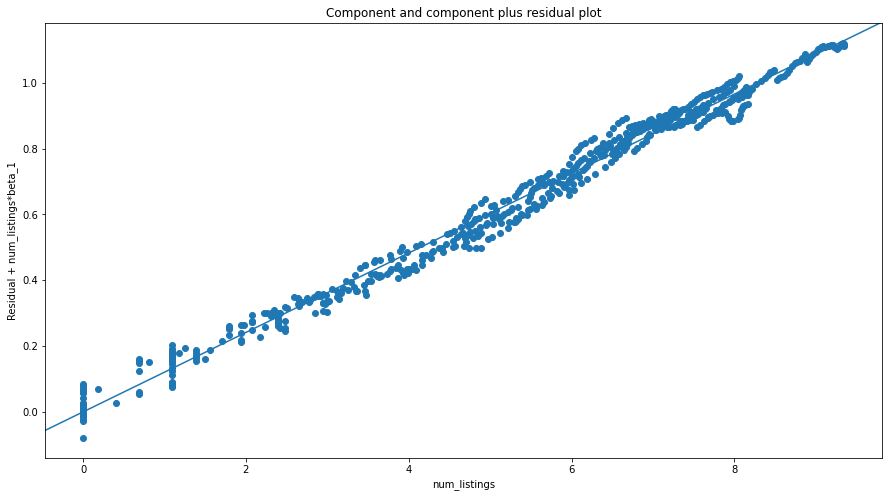

In [32]:
fig = sm.graphics.plot_ccpr(result, "num_listings")
fig.set_size_inches(15, 8)

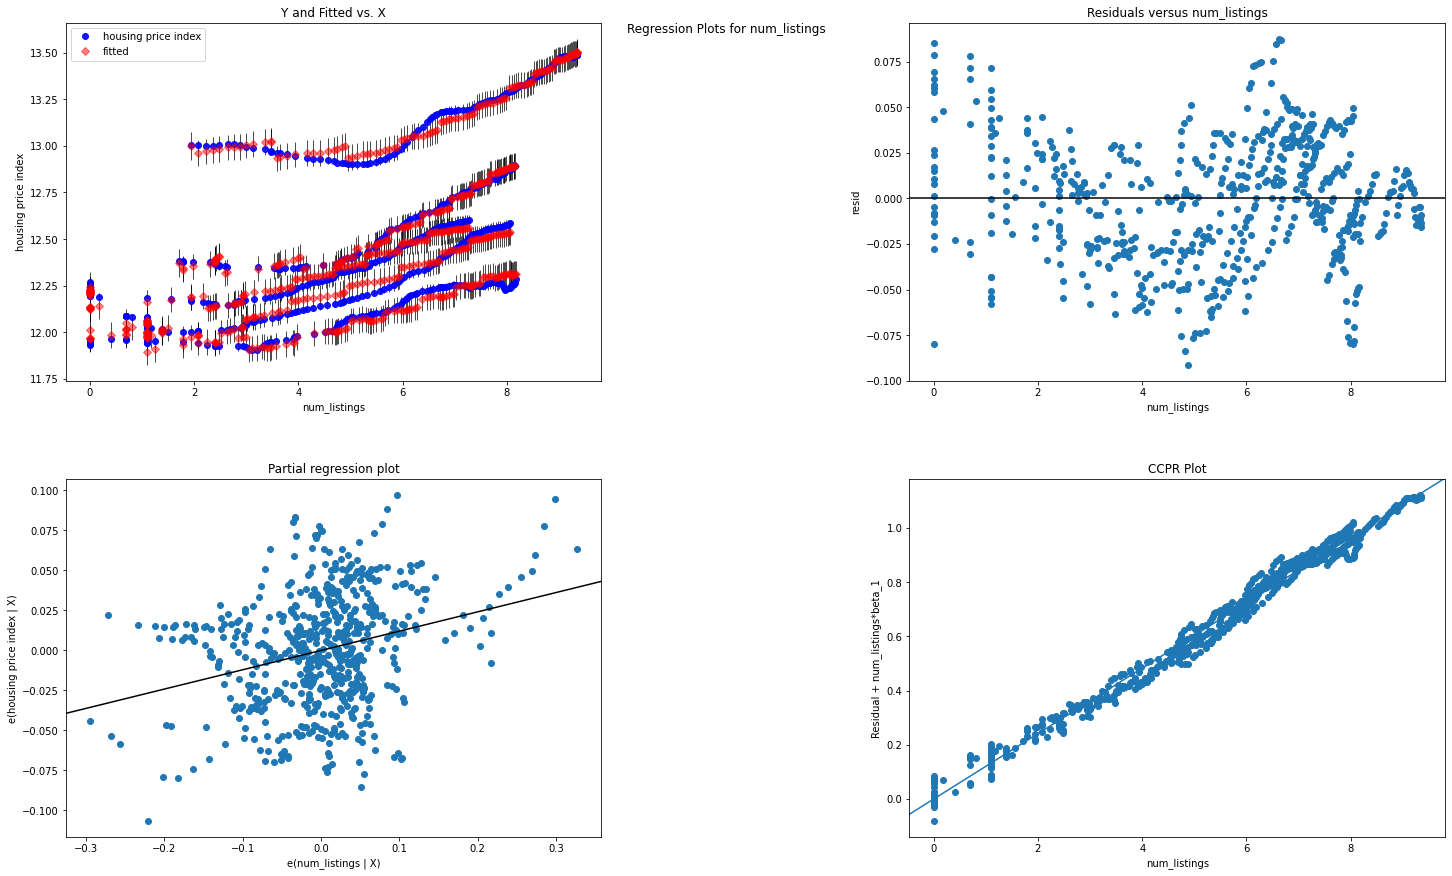

In [33]:
fig = sm.graphics.plot_regress_exog(result, "num_listings")
fig.set_size_inches(20, 12)
fig.tight_layout(pad=0.1,h_pad = 5, w_pad = 25)

In [34]:
xx1, xx2 = np.meshgrid(np.linspace(X.num_listings.min(), X.num_listings.max(), 100),
np.linspace(X.GDP.min(), X.GDP.max(), 100))
# plot the hyperplane by evaluating the parameters on the grid
Z = result.params[0] + result.params[1] * xx1 + result.params[2] * xx2

In [35]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0, 'HPI')

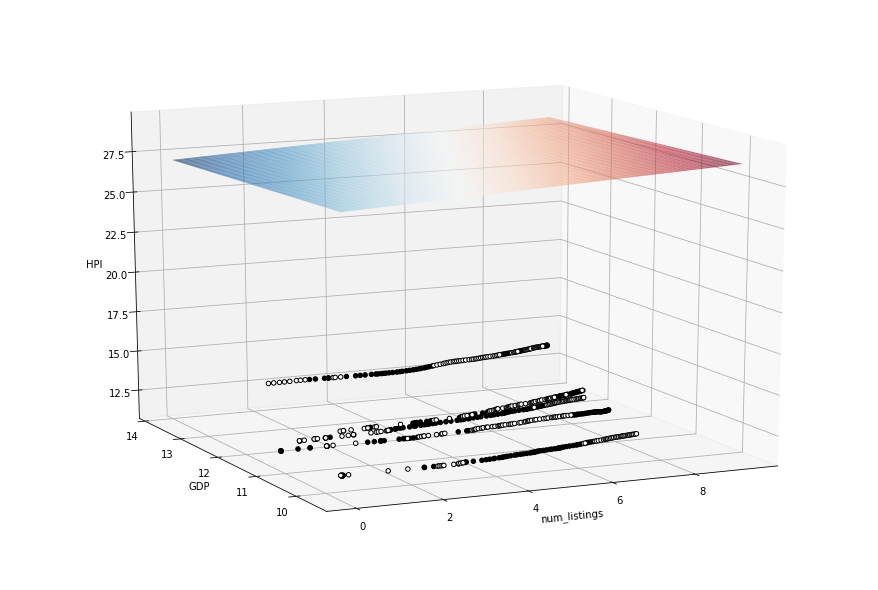

In [36]:
# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)

# plot hyperplane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)

# plot data points - points over the HP are white, points below are black
resid = y - result.predict(X)
ax.scatter(X[resid >= 0].num_listings, X[resid >= 0].GDP, y[resid >= 0], color='black', alpha=1.0, facecolor='white')
ax.scatter(X[resid < 0].num_listings, X[resid < 0].GDP, y[resid < 0], color='black', alpha=1.0)

# set axis labels
ax.set_xlabel('num_listings')
ax.set_ylabel('GDP')
ax.set_zlabel('HPI')

In [37]:
# run OLS model - WITHOUT LA
df_no_la = df.loc[df['city'] != 'Los Angeles']
y = df_no_la['housing price index']
X = sm.add_constant(df_no_la[['num_listings','listing x occupancy','GDP','PI','population',\
                        'unemployment rate','Asheville','Austin','Nashville', \
                        '2009', '2010', '2011', '2012', '2013', '2014', '2015', \
                        '2016', '2017', '2018']])
result = sm.OLS(y, X).fit(cov_type='HC1')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     housing price index   R-squared:                       0.986
Model:                             OLS   Adj. R-squared:                  0.985
Method:                  Least Squares   F-statistic:                     2476.
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:42:01   Log-Likelihood:                 999.75
No. Observations:                  480   AIC:                            -1960.
Df Residuals:                      460   BIC:                            -1876.
Df Model:                           19                                         
Covariance Type:                   HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.2249      5.693     -0.918      0.359     -16.383       5.933
num_listings            0.1735      0.016     10.967      0.000       0.143       0.205
listing x occupancy    -0.1491      0.017     -8.821      0.000      -0.182      -0.116
GDP                    -2.4846      0.771     -3.222      0.001      -3.996      -0.973
PI                      1.2760      0.832      1.533      0.125      -0.355       2.907
population              4.3963      0.750      5.859      0.000       2.926       5.867
unemployment rate      -0.0069      0.003     -2.652      0.008      -0.012      -0.002
Asheville               1.5012      0.271      5.540      0.000       0.970       2.032
Austin                 -0.3006      0.043     -7.012      0.000      -0.385      -0.217
Nashville              -0.4182      0.033    -12.497      0.000      -0.484      -0.353
2009                   -0.0259      0.052     -0.501      0.616      -0.127       0.075
2010                   -0.0545      0.048     -1.137      0.255      -0.148       0.039
2011                   -0.1327      0.043     -3.115      0.002      -0.216      -0.049
2012                   -0.1966      0.037     -5.341      0.000      -0.269      -0.124
2013                   -0.1753      0.032     -5.414      0.000      -0.239      -0.112
2014                   -0.1374      0.027     -5.051      0.000      -0.191      -0.084
2015                   -0.1013      0.023     -4.463      0.000      -0.146      -0.057
2016                   -0.0554      0.017     -3.257      0.001      -0.089      -0.022
2017                   -0.0229      0.012     -1.837      0.066      -0.047       0.002
2018                    0.0004      0.009      0.044      0.965      -0.018       0.019
==============================================================================
Omnibus:                       17.719   Durbin-Watson:                   0.207
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.618
Skew:                           0.155   Prob(JB):                      0.00816
Kurtosis:                       2.379   Cond. No.                     7.58e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 7.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# **Part 2. Two Stage Least Squares**

## Data Processing & Instrumental Variable Justification





In [38]:
# Reload the dataset to perform two stage least squares.
df = pd.read_csv(r'https://media.githubusercontent.com/media/conguflama/Citadel-Summer-Datathon/main/data/cleaned_dataset/cleaned_dataset_monthly.csv')

In [39]:
df_IV = df.copy()
# Define a function to get the time series HPI of every city.
def get_log_hpi(df, city):
  df_city = df[df['city'] == city].copy()
  df_city = df_city[['Year_month', 'housing price index']]
  df_city['date'] = pd.to_datetime(df_city['Year_month'])
  df_city = df_city[df_city['date'] < "2020-01-01"]

  baseline = df_city[df_city['Year_month'] == '2011-06']['housing price index'].iloc[0]
  std = np.std(df_city['housing price index'])
  df_city['housing price index'] = (df_city['housing price index'] - baseline)/std
  df_city = df_city.rename(columns = {'housing price index': city})
  df_city = df_city.drop(columns = 'date')
  return df_city

In [40]:
# get the time series HPI of every city.
hpi_log_la = get_log_hpi(df_IV,'Los Angeles')
hpi_log_NO = get_log_hpi(df_IV, 'New Orleans')
hpi_log_NA = get_log_hpi(df_IV, 'Nashville')
hpi_log_Aus = get_log_hpi(df_IV, 'Austin')
hpi_log_Ash = get_log_hpi(df_IV, 'Asheville')
hpi_log_la

,Year_month,Los Angeles
2,2009-12,0.280521
7,2010-01,0.285878
12,2010-02,0.265938
17,2010-03,0.261944
22,2010-04,0.271457
...,...,...
577,2019-07,2.753622
582,2019-08,2.744271
587,2019-09,2.732695
592,2019-10,2.756799


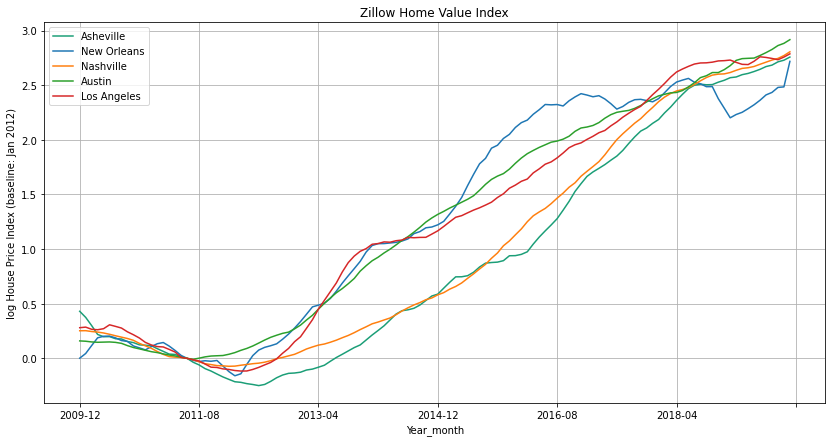

In [41]:
# Plot the HPI series for every city to see if the pre-trend are the same before 2010.
ax = hpi_log_Ash.plot(x='Year_month', y='Asheville', colormap='Dark2', figsize=(14, 7))
ax.set_xlabel('Year')
ax.set_ylabel('log House Price Index (baseline: Jan 2012)')
ax.set_title('Zillow Home Value Index')

hpi_log_NO.plot(x='Year_month', y='New Orleans', ax=ax)
hpi_log_NA.plot(x='Year_month', y='Nashville', ax=ax)
hpi_log_Aus.plot(x='Year_month', y='Austin', ax=ax)
hpi_log_la.plot(x='Year_month', y='Los Angeles', ax=ax)
plt.grid()
plt.show()

In [42]:
# Check the IV validity.
median = np.median(estab['Establishment'])
estab['touristiness'] = estab['Establishment'] > median
estab['touristiness'] = estab['touristiness'].astype(int)
estab = estab.rename(columns = {'MSA': 'city'})
estab

,city,Establishment,touristiness
0,Austin,40281,1
1,Asheville,11639,0
2,Los Angeles,333006,1
3,Nashville,37883,0
4,New Orleans,29100,0


In [43]:
# Join the listing data with touristiness.
df_IV = pd.merge(df_IV, estab, on=['city'], how = 'inner')
df_IV

,Unnamed: 0,Year_month,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,Establishment,touristiness
0,0,2009-12,Asheville,0.00,22222.0,14418.294867,34399.972097,414.327117,7.4,213247.0,31.2,11639,0
1,5,2010-01,Asheville,0.00,17042.0,14464.649080,34472.634578,414.751723,8.0,211234.0,31.2,11639,0
2,10,2010-02,Asheville,0.00,17917.0,14511.003292,34545.297059,415.176328,7.9,208515.0,31.2,11639,0
3,15,2010-03,Asheville,0.00,25708.0,14557.357505,34617.959540,415.600933,7.7,205576.0,31.2,11639,0
4,20,2010-04,Asheville,0.00,29669.0,14603.711718,34690.622021,416.025539,7.0,204818.0,31.2,11639,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,579,2019-07,New Orleans,3276.75,544681.0,81709.215736,49831.650339,1238.269717,5.5,209841.0,37.6,29100,0
596,584,2019-08,New Orleans,3331.00,537033.0,81844.314884,49918.475475,1238.234596,5.3,210392.0,37.6,29100,0
597,589,2019-09,New Orleans,3398.80,528048.0,81979.414033,50005.300611,1238.199475,4.7,211490.0,37.6,29100,0
598,594,2019-10,New Orleans,3505.00,626430.0,82114.513182,50092.125747,1238.164353,4.8,211607.0,37.6,29100,0


In [44]:
# Join the google index series.
google_index = pd.read_csv('https://media.githubusercontent.com/media/conguflama/Citadel-Summer-Datathon/main/data/goole%20index%26estab/google_index.csv')
google_index = google_index.iloc[:, 1:]
google_index = google_index.rename(columns = {'month':'Year_month'})
df_IV = pd.merge(df_IV, google_index, on=['Year_month'], how = 'inner')
df_IV

,Unnamed: 0,Year_month,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,Establishment,touristiness,airbnb
0,0,2009-12,Asheville,0.00,22222.0,1.441829e+04,34399.972097,414.327117,7.4,213247.0,31.2,11639,0,0
1,1,2009-12,Austin,4.50,329526.0,9.127099e+04,42465.021267,1697.808073,6.4,238387.0,17.9,40281,1,0
2,2,2009-12,Los Angeles,6.00,2334939.0,7.488626e+05,44175.589140,12926.602218,13.4,444590.0,29.0,333006,1,0
3,3,2009-12,Nashville,1.00,343003.0,8.630290e+04,42337.457466,1599.243444,9.0,177900.0,34.0,37883,0,0
4,4,2009-12,New Orleans,0.00,315363.0,6.617281e+04,39846.759729,1242.308644,7.6,151936.0,31.6,29100,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,2019-11,Asheville,1441.50,69394.0,1.993445e+04,43046.807353,464.855148,2.6,297489.0,40.1,11639,0,69
596,596,2019-11,Austin,3429.50,703163.0,1.470664e+05,53558.440882,2207.648209,2.4,399216.0,23.9,40281,1,69
597,597,2019-11,Los Angeles,11339.00,3242638.0,1.031996e+06,55398.495294,13244.111888,4.3,723837.0,32.5,333006,1,69
598,598,2019-11,Nashville,3139.25,726092.0,1.307348e+05,53441.159902,1934.070099,2.4,292210.0,41.7,37883,0,69


In [45]:
df_pv = df_IV[['Year_month', 'touristiness', 'num_listings']]
pivot = pd.pivot_table(df_pv, index=['Year_month'], columns=['touristiness'], values=['num_listings'], aggfunc=np.mean).reset_index()
pivot.columns = ['Year_month', 'low_tour', 'high_tour']
pivot = pd.merge(google_index, pivot, on=['Year_month'])
pivot['diff'] = pivot['high_tour'] - pivot['low_tour']
pivot

,Year_month,airbnb,low_tour,high_tour,diff
0,2009-12,0,0.333333,5.250,4.916667
1,2010-01,0,0.333333,6.000,5.666667
2,2010-02,0,0.333333,6.625,6.291667
3,2010-03,0,0.333333,7.875,7.541667
4,2010-04,0,0.583333,10.000,9.416667
...,...,...,...,...,...
115,2019-07,100,2457.583333,7270.750,4813.166667
116,2019-08,91,2512.166667,7350.750,4838.583333
117,2019-09,77,2585.733333,7403.900,4818.166667
118,2019-10,74,2670.000000,7463.125,4793.125000


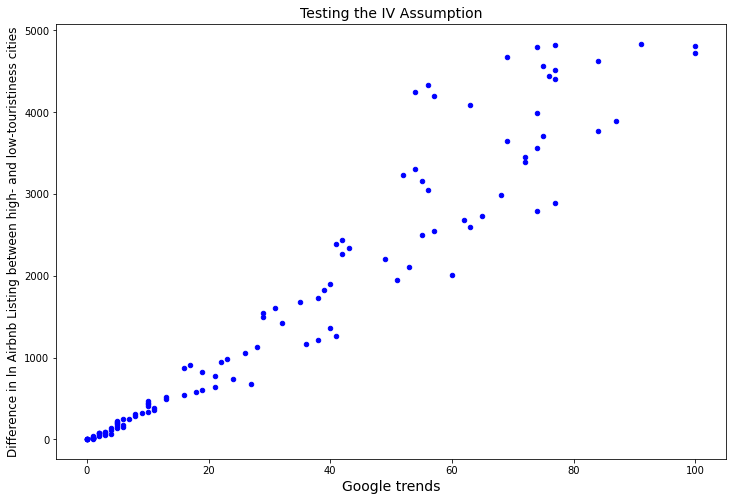

In [46]:
# Plot the correlation between google trends and difference in Airbnb listings between high- and low touristiness areas.
ax = pivot.plot(x='airbnb', y='diff', color='b', kind='scatter', figsize=(12, 8))
ax.set_xlabel('Google trends', fontsize=14)
ax.set_ylabel('Difference in ln Airbnb Listing between high- and low-touristiness cities', fontsize=12)
ax.set_title('Testing the IV Assumption', fontsize=14)
plt.show()

In [47]:
# to take log of variables.
to_log_columns = ['num_listings','Passenger','GDP','PI','population', \
                  'housing price index']
for column in to_log_columns:
  df[column] = np.log(df[column]+1)
df.head()

,Unnamed: 0,Year_month,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education
0,0,2009-12,Asheville,0.000000,10.008883,9.576323,10.445840,6.029066,7.4,12.270211,31.2
1,1,2009-12,Austin,1.704748,12.705414,11.421599,10.656460,7.437682,6.4,12.381655,17.9
2,2,2009-12,Los Angeles,1.945910,14.663497,13.526312,10.695950,9.467120,13.4,13.004910,29.0
3,3,2009-12,Nashville,0.693147,12.745497,11.365630,10.653451,7.377911,9.0,12.088982,34.0
4,4,2009-12,New Orleans,0.000000,12.661483,11.100040,10.592821,7.125531,7.6,11.931221,31.6


In [48]:
google_index

,Year_month,airbnb
0,2009-01,0
1,2009-02,0
2,2009-03,0
3,2009-04,0
4,2009-05,0
...,...,...
127,2019-08,91
128,2019-09,77
129,2019-10,74
130,2019-11,69


In [49]:
# Add control variables.
google_index = google_index.rename(columns = {'month':'Year_month'})
df2 = pd.merge(df, google_index, on=['Year_month'], how = 'inner')
estab = estab.rename(columns = {'MSA':'city'})
df2 = pd.merge(df2, estab, on=['city'], how = 'inner')

In [50]:
df2 = pd.merge(df2, occupancy_rate, on=['city'])
df2

,Unnamed: 0,Year_month,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,airbnb,Establishment,touristiness,occupancy_rate
0,0,2009-12,Asheville,0.000000,10.008883,9.576323,10.445840,6.029066,7.4,12.270211,31.2,0,11639,0,0.904
1,5,2010-01,Asheville,0.000000,9.743495,9.579532,10.447950,6.030088,8.0,12.260727,31.2,0,11639,0,0.904
2,10,2010-02,Asheville,0.000000,9.793561,9.582731,10.450056,6.031109,7.9,12.247771,31.2,0,11639,0,0.904
3,15,2010-03,Asheville,0.000000,10.154596,9.585921,10.452157,6.032129,7.7,12.233576,31.2,0,11639,0,0.904
4,20,2010-04,Asheville,0.000000,10.297892,9.589099,10.454253,6.033147,7.0,12.229882,31.2,0,11639,0,0.904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,579,2019-07,New Orleans,8.094912,13.207957,11.310934,10.816426,7.122278,5.5,12.254110,37.6,100,29100,0,0.725
596,584,2019-08,New Orleans,8.111328,13.193817,11.312586,10.818166,7.122249,5.3,12.256732,37.6,91,29100,0,0.725
597,589,2019-09,New Orleans,8.131472,13.176944,11.314236,10.819904,7.122221,4.7,12.261938,37.6,77,29100,0,0.725
598,594,2019-10,New Orleans,8.162231,13.347794,11.315882,10.821639,7.122193,4.8,12.262491,37.6,74,29100,0,0.725


In [51]:
df2['airbnb*Establishment'] = df2['airbnb'] * df2['Establishment']
df2['airbnb*Estab*occup'] = df2['airbnb'] * df2['Establishment'] * df2['occupancy_rate']

In [52]:
df2['listing x occupancy'] = df2['num_listings'] * df2['occupancy_rate']
df_before_one_hot = df2.copy()
df2

,Unnamed: 0,Year_month,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,airbnb,Establishment,touristiness,occupancy_rate,airbnb*Establishment,airbnb*Estab*occup,listing x occupancy
0,0,2009-12,Asheville,0.000000,10.008883,9.576323,10.445840,6.029066,7.4,12.270211,31.2,0,11639,0,0.904,0,0.0,0.000000
1,5,2010-01,Asheville,0.000000,9.743495,9.579532,10.447950,6.030088,8.0,12.260727,31.2,0,11639,0,0.904,0,0.0,0.000000
2,10,2010-02,Asheville,0.000000,9.793561,9.582731,10.450056,6.031109,7.9,12.247771,31.2,0,11639,0,0.904,0,0.0,0.000000
3,15,2010-03,Asheville,0.000000,10.154596,9.585921,10.452157,6.032129,7.7,12.233576,31.2,0,11639,0,0.904,0,0.0,0.000000
4,20,2010-04,Asheville,0.000000,10.297892,9.589099,10.454253,6.033147,7.0,12.229882,31.2,0,11639,0,0.904,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,579,2019-07,New Orleans,8.094912,13.207957,11.310934,10.816426,7.122278,5.5,12.254110,37.6,100,29100,0,0.725,2910000,2109750.0,5.868812
596,584,2019-08,New Orleans,8.111328,13.193817,11.312586,10.818166,7.122249,5.3,12.256732,37.6,91,29100,0,0.725,2648100,1919872.5,5.880713
597,589,2019-09,New Orleans,8.131472,13.176944,11.314236,10.819904,7.122221,4.7,12.261938,37.6,77,29100,0,0.725,2240700,1624507.5,5.895317
598,594,2019-10,New Orleans,8.162231,13.347794,11.315882,10.821639,7.122193,4.8,12.262491,37.6,74,29100,0,0.725,2153400,1561215.0,5.917618


In [53]:
# one-hot city column
df2 = df2.iloc[:,1:].join(pd.get_dummies(df2.city))

# one-hot date column by year
df2['Year_month'] = df2['Year_month'].map(lambda x: x.split('-')[0])
df2 = df2.iloc[:,1:].join(pd.get_dummies(df2.Year_month))
df2

,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,airbnb,Establishment,touristiness,occupancy_rate,airbnb*Establishment,airbnb*Estab*occup,listing x occupancy,Asheville,Austin,Los Angeles,Nashville,New Orleans,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Asheville,0.000000,10.008883,9.576323,10.445840,6.029066,7.4,12.270211,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Asheville,0.000000,9.743495,9.579532,10.447950,6.030088,8.0,12.260727,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Asheville,0.000000,9.793561,9.582731,10.450056,6.031109,7.9,12.247771,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Asheville,0.000000,10.154596,9.585921,10.452157,6.032129,7.7,12.233576,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Asheville,0.000000,10.297892,9.589099,10.454253,6.033147,7.0,12.229882,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,New Orleans,8.094912,13.207957,11.310934,10.816426,7.122278,5.5,12.254110,37.6,100,29100,0,0.725,2910000,2109750.0,5.868812,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
596,New Orleans,8.111328,13.193817,11.312586,10.818166,7.122249,5.3,12.256732,37.6,91,29100,0,0.725,2648100,1919872.5,5.880713,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
597,New Orleans,8.131472,13.176944,11.314236,10.819904,7.122221,4.7,12.261938,37.6,77,29100,0,0.725,2240700,1624507.5,5.895317,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
598,New Orleans,8.162231,13.347794,11.315882,10.821639,7.122193,4.8,12.262491,37.6,74,29100,0,0.725,2153400,1561215.0,5.917618,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [54]:
# Add scaled IV candidates.
df2['estab_density'] = df2['Establishment'] / df2['population']
df2['airbnb*estab_density'] = df2['airbnb'] * df2['estab_density']
df2['airbnb*estab_density_occup'] = df2['airbnb'] * df2['estab_density'] * df2['occupancy_rate']
df2['airbnb*occup'] = df2['airbnb'] * df2['occupancy_rate']
df2

,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,airbnb,Establishment,touristiness,occupancy_rate,airbnb*Establishment,airbnb*Estab*occup,listing x occupancy,Asheville,Austin,Los Angeles,Nashville,New Orleans,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,estab_density,airbnb*estab_density,airbnb*estab_density_occup,airbnb*occup
0,Asheville,0.000000,10.008883,9.576323,10.445840,6.029066,7.4,12.270211,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1930.481296,0.000000,0.000000,0.000
1,Asheville,0.000000,9.743495,9.579532,10.447950,6.030088,8.0,12.260727,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1930.154169,0.000000,0.000000,0.000
2,Asheville,0.000000,9.793561,9.582731,10.450056,6.031109,7.9,12.247771,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1929.827488,0.000000,0.000000,0.000
3,Asheville,0.000000,10.154596,9.585921,10.452157,6.032129,7.7,12.233576,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1929.501250,0.000000,0.000000,0.000
4,Asheville,0.000000,10.297892,9.589099,10.454253,6.033147,7.0,12.229882,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1929.175455,0.000000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,New Orleans,8.094912,13.207957,11.310934,10.816426,7.122278,5.5,12.254110,37.6,100,29100,0,0.725,2910000,2109750.0,5.868812,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4085.771694,408577.169422,296218.447831,72.500
596,New Orleans,8.111328,13.193817,11.312586,10.818166,7.122249,5.3,12.256732,37.6,91,29100,0,0.725,2648100,1919872.5,5.880713,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4085.787952,371806.703646,269559.860143,65.975
597,New Orleans,8.131472,13.176944,11.314236,10.819904,7.122221,4.7,12.261938,37.6,77,29100,0,0.725,2240700,1624507.5,5.895317,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4085.804211,314606.924222,228090.020061,55.825
598,New Orleans,8.162231,13.347794,11.315882,10.821639,7.122193,4.8,12.262491,37.6,74,29100,0,0.725,2153400,1561215.0,5.917618,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4085.820470,302350.714765,219204.268205,53.650


In [55]:
# !pip install glmnet
df2[df2['airbnb*estab_density'].isnull()]

,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,airbnb,Establishment,touristiness,occupancy_rate,airbnb*Establishment,airbnb*Estab*occup,listing x occupancy,Asheville,Austin,Los Angeles,Nashville,New Orleans,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,estab_density,airbnb*estab_density,airbnb*estab_density_occup,airbnb*occup


## Two Stage Regression

In [56]:
# First stage on num_listings.
first_y = df2['num_listings']

first_X = sm.add_constant(df2[['airbnb*Establishment', 'airbnb*Estab*occup', 'GDP','PI','population','unemployment rate','Los Angeles', 'Asheville','Austin','Nashville', 
                          '2009','2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018']])

result = sm.OLS(first_y, first_X).fit(cov_type='HC1')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_listings   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1280.
Date:                Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:42:02   Log-Likelihood:                -114.85
No. Observations:                 600   AIC:                             271.7
Df Residuals:                     579   BIC:                             364.0
Df Model:                          20                                         
Covariance Type:                  HC1                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -396.3283     30.622    -12.943      0.000    -456.346    -336.311
airbnb*Establishment -1.251e-06   2.31e-07     -5.426      0.000    -1.7e-06   -7.99e-07
airbnb*Estab*occup    1.295e-06   2.46e-07      5.274      0.000    8.14e-07    1.78e-06
GDP                     -8.5143      3.887     -2.190      0.029     -16.133      -0.895
PI                      46.0009      4.284     10.737      0.000      37.604      54.398
population               0.6141      3.682      0.167      0.868      -6.603       7.831
unemployment rate       -0.0611      0.021     -2.960      0.003      -0.102      -0.021
Los Angeles             17.0152      1.746      9.746      0.000      13.593      20.437
Asheville               -6.3338      1.585     -3.996      0.000      -9.441      -3.227
Austin                   1.0816      0.294      3.682      0.000       0.506       1.657
Nashville               -0.7026      0.235     -2.994      0.003      -1.163      -0.243
2009                    -0.0510      0.455     -0.112      0.911      -0.943       0.841
2010                    -0.0254      0.379     -0.067      0.947      -0.769       0.718
2011                     0.2003      0.350      0.572      0.567      -0.486       0.886
2012                     0.6714      0.290      2.311      0.021       0.102       1.241
2013                     0.7585      0.252      3.014      0.003       0.265       1.252
2014                     0.7727      0.207      3.738      0.000       0.368       1.178
2015                     0.7832      0.168      4.674      0.000       0.455       1.112
2016                     0.7211      0.130      5.543      0.000       0.466       0.976
2017                     0.5717      0.095      5.991      0.000       0.385       0.759
2018                     0.2990      0.069      4.337      0.000       0.164       0.434
==============================================================================
Omnibus:                       32.319   Durbin-Watson:                   0.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.204
Skew:                          -0.540   Prob(JB):                     8.34e-09
Kurtosis:                       3.568   Cond. No.                     2.36e+10
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.36e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
# First stage on second IV.
first_y1 = df2['listing x occupancy']

first_X1 = sm.add_constant(df2[['airbnb*Establishment', 'airbnb*Estab*occup','GDP','PI','population','unemployment rate','Los Angeles', 'Asheville','Austin','Nashville', 
                          '2009','2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018']])

result_fs = sm.OLS(first_y1, first_X1).fit(cov_type='HC1')
result_fs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     listing x occupancy   R-squared:                       0.985
Model:                             OLS   Adj. R-squared:                  0.984
Method:                  Least Squares   F-statistic:                     1448.
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:42:02   Log-Likelihood:                -77.945
No. Observations:                  600   AIC:                             197.9
Df Residuals:                      579   BIC:                             290.2
Df Model:                           20                                         
Covariance Type:                   HC1                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -243.2428     28.527     -8.527      0.000    -299.155    -187.330
airbnb*Establishment -2.356e-06   2.38e-07     -9.915      0.000   -2.82e-06   -1.89e-06
airbnb*Estab*occup    2.464e-06   2.53e-07      9.755      0.000    1.97e-06    2.96e-06
GDP                      7.4167      3.998      1.855      0.064      -0.420      15.253
PI                      22.4868      4.124      5.452      0.000      14.403      30.570
population             -10.7051      3.826     -2.798      0.005     -18.203      -3.207
unemployment rate       -0.0600      0.019     -3.127      0.002      -0.098      -0.022
Los Angeles              7.3754      1.650      4.470      0.000       4.141      10.610
Asheville                2.5549      1.586      1.611      0.107      -0.553       5.663
Austin                   1.0317      0.281      3.675      0.000       0.481       1.582
Nashville               -0.4460      0.223     -1.998      0.046      -0.883      -0.009
2009                    -0.4734      0.404     -1.171      0.242      -1.266       0.319
2010                    -0.4671      0.349     -1.337      0.181      -1.151       0.217
2011                    -0.2931      0.316     -0.927      0.354      -0.913       0.327
2012                     0.1249      0.263      0.476      0.634      -0.390       0.640
2013                     0.2117      0.227      0.933      0.351      -0.233       0.656
2014                     0.2740      0.186      1.471      0.141      -0.091       0.639
2015                     0.3540      0.151      2.347      0.019       0.058       0.650
2016                     0.3749      0.117      3.199      0.001       0.145       0.605
2017                     0.3414      0.087      3.915      0.000       0.170       0.512
2018                     0.1719      0.065      2.629      0.009       0.044       0.300
==============================================================================
Omnibus:                       43.087   Durbin-Watson:                   0.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.765
Skew:                          -0.645   Prob(JB):                     5.75e-12
Kurtosis:                       3.639   Cond. No.                     2.36e+10
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.36e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
# Second Stage of TSLS.
df2['predicted_num_listings'] = result.predict()
df2['predicted_listing_x_occup'] = result_fs.predict()

second_y = np.log(df2['housing price index'])
second_X = sm.add_constant(df2[['predicted_num_listings','predicted_listing_x_occup','GDP','PI','population','unemployment rate','Los Angeles', 'Asheville','Austin','Nashville', 
                          '2009','2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018' ]])
results_ss = sm.OLS(second_y, second_X).fit(cov_type = 'HC1')
print(results_ss.summary())

                             OLS Regression Results                            
Dep. Variable:     housing price index   R-squared:                       0.993
Model:                             OLS   Adj. R-squared:                  0.993
Method:                  Least Squares   F-statistic:                 1.298e+04
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:42:02   Log-Likelihood:                 2672.9
No. Observations:                  600   AIC:                            -5304.
Df Residuals:                      579   BIC:                            -5212.
Df Model:                           20                                         
Covariance Type:                   HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const       

In [59]:
df2

,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,airbnb,Establishment,touristiness,occupancy_rate,airbnb*Establishment,airbnb*Estab*occup,listing x occupancy,Asheville,Austin,Los Angeles,Nashville,New Orleans,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,estab_density,airbnb*estab_density,airbnb*estab_density_occup,airbnb*occup,predicted_num_listings,predicted_listing_x_occup
0,Asheville,0.000000,10.008883,9.576323,10.445840,6.029066,7.4,12.270211,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1930.481296,0.000000,0.000000,0.000,-0.480600,-0.229508
1,Asheville,0.000000,9.743495,9.579532,10.447950,6.030088,8.0,12.260727,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1930.154169,0.000000,0.000000,0.000,-0.421275,-0.198849
2,Asheville,0.000000,9.793561,9.582731,10.450056,6.031109,7.9,12.247771,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1929.827488,0.000000,0.000000,0.000,-0.344921,-0.132701
3,Asheville,0.000000,10.154596,9.585921,10.452157,6.032129,7.7,12.233576,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1929.501250,0.000000,0.000000,0.000,-0.262575,-0.060716
4,Asheville,0.000000,10.297892,9.589099,10.454253,6.033147,7.0,12.229882,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1929.175455,0.000000,0.000000,0.000,-0.149800,0.041108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,New Orleans,8.094912,13.207957,11.310934,10.816426,7.122278,5.5,12.254110,37.6,100,29100,0,0.725,2910000,2109750.0,5.868812,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4085.771694,408577.169422,296218.447831,72.500,8.060869,5.639188
596,New Orleans,8.111328,13.193817,11.312586,10.818166,7.122249,5.3,12.256732,37.6,91,29100,0,0.725,2648100,1919872.5,5.880713,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4085.787952,371806.703646,269559.860143,65.975,8.220897,5.852218
597,New Orleans,8.131472,13.176944,11.314236,10.819904,7.122221,4.7,12.261938,37.6,77,29100,0,0.725,2240700,1624507.5,5.895317,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4085.804211,314606.924222,228090.020061,55.825,8.450698,6.172122
598,New Orleans,8.162231,13.347794,11.315882,10.821639,7.122193,4.8,12.262491,37.6,74,29100,0,0.725,2153400,1561215.0,5.917618,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4085.820470,302350.714765,219204.268205,53.650,8.537624,6.267422


In [60]:
# No la. Firts stage on first IV.
df_no_la = df2.loc[df2['city'] != 'Los Angeles']
first_y_2 = df_no_la['num_listings']

first_X_2 = sm.add_constant(df_no_la[['airbnb*Establishment', 'airbnb*Estab*occup','GDP','PI','population','unemployment rate', 'Asheville','Austin','Nashville', '2009',
                          '2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018']])

result = sm.OLS(first_y_2, first_X_2).fit(cov_type='HC1')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_listings   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     810.7
Date:                Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:42:02   Log-Likelihood:                -72.720
No. Observations:                 480   AIC:                             185.4
Df Residuals:                     460   BIC:                             268.9
Df Model:                          19                                         
Covariance Type:                  HC1                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -28.1083     51.831     -0.542      0.588    -129.696      73.479
airbnb*Establishment  -4.76e-06   4.19e-07    -11.367      0.000   -5.58e-06   -3.94e-06
airbnb*Estab*occup    5.575e-06   4.91e-07     11.350      0.000    4.61e-06    6.54e-06
GDP                     50.7105      9.343      5.428      0.000      32.399      69.022
PI                      -4.7273      8.108     -0.583      0.560     -20.618      11.163
population             -67.9725      9.709     -7.001      0.000     -87.001     -48.944
unemployment rate       -0.0400      0.026     -1.560      0.119      -0.090       0.010
Asheville                1.3014      2.737      0.476      0.634      -4.062       6.665
Austin                   6.7772      0.607     11.162      0.000       5.587       7.967
Nashville                3.6254      0.437      8.298      0.000       2.769       4.482
2009                     0.4201      0.513      0.819      0.413      -0.586       1.426
2010                     0.2484      0.425      0.584      0.559      -0.585       1.081
2011                     0.2258      0.383      0.589      0.556      -0.525       0.977
2012                     0.6565      0.314      2.088      0.037       0.040       1.273
2013                     0.6887      0.269      2.559      0.010       0.161       1.216
2014                     0.6710      0.221      3.032      0.002       0.237       1.105
2015                     0.6598      0.178      3.701      0.000       0.310       1.009
2016                     0.6001      0.136      4.416      0.000       0.334       0.866
2017                     0.4456      0.098      4.562      0.000       0.254       0.637
2018                     0.2445      0.068      3.582      0.000       0.111       0.378
==============================================================================
Omnibus:                       25.400   Durbin-Watson:                   0.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.915
Skew:                          -0.526   Prob(JB):                     5.26e-07
Kurtosis:                       3.584   Cond. No.                     7.71e+09
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 7.71e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
# No la. First Stage on second IV.
first_y1_no = df_no_la['listing x occupancy']

first_X1_no = sm.add_constant(df_no_la[['airbnb*Establishment', 'airbnb*Estab*occup','GDP','PI','population','unemployment rate', 'Asheville','Austin','Nashville', 
                          '2009','2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018']])

result_fs = sm.OLS(first_y1_no, first_X1_no).fit(cov_type='HC1')
result_fs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     listing x occupancy   R-squared:                       0.984
Model:                             OLS   Adj. R-squared:                  0.983
Method:                  Least Squares   F-statistic:                     894.5
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:42:02   Log-Likelihood:                -43.948
No. Observations:                  480   AIC:                             127.9
Df Residuals:                      460   BIC:                             211.4
Df Model:                           19                                         
Covariance Type:                   HC1                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  111.8721     47.748      2.343      0.019      18.289     205.456
airbnb*Establishment -5.301e-06   4.25e-07    -12.478      0.000   -6.13e-06   -4.47e-06
airbnb*Estab*occup    6.003e-06   4.92e-07     12.204      0.000    5.04e-06    6.97e-06
GDP                     65.2233      8.829      7.387      0.000      47.918      82.529
PI                     -27.8342      7.481     -3.720      0.000     -42.498     -13.171
population             -75.8239      9.268     -8.182      0.000     -93.988     -57.660
unemployment rate       -0.0386      0.023     -1.657      0.097      -0.084       0.007
Asheville               11.8303      2.502      4.728      0.000       6.926      16.735
Austin                   5.9766      0.583     10.252      0.000       4.834       7.119
Nashville                3.3171      0.422      7.865      0.000       2.490       4.144
2009                    -0.1324      0.459     -0.288      0.773      -1.032       0.767
2010                    -0.3181      0.398     -0.799      0.425      -1.099       0.463
2011                    -0.3910      0.350     -1.118      0.264      -1.077       0.295
2012                    -0.0196      0.287     -0.068      0.946      -0.582       0.543
2013                     0.0150      0.245      0.061      0.951      -0.464       0.494
2014                     0.0605      0.200      0.302      0.763      -0.332       0.453
2015                     0.1393      0.161      0.867      0.386      -0.176       0.454
2016                     0.1845      0.123      1.498      0.134      -0.057       0.426
2017                     0.1760      0.090      1.964      0.050       0.000       0.352
2018                     0.0936      0.065      1.444      0.149      -0.033       0.221
==============================================================================
Omnibus:                       37.914   Durbin-Watson:                   0.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.350
Skew:                          -0.639   Prob(JB):                     3.17e-11
Kurtosis:                       3.885   Cond. No.                     7.71e+09
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 7.71e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
# No la. Second stage of TSLS.
df_no_la['predicted_num_listings'] = result.predict()
df_no_la['predicted_listing_x_occup'] =result_fs.predict()

second_y = np.log(df_no_la['housing price index'])
second_X = sm.add_constant(df_no_la[['predicted_num_listings','predicted_listing_x_occup','GDP','PI','population','unemployment rate', 'Asheville','Austin','Nashville', 
                          '2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018' ]])
results_ss = sm.OLS(second_y, second_X).fit(cov_type = 'HC1')
print(results_ss.summary())

                             OLS Regression Results                            
Dep. Variable:     housing price index   R-squared:                       0.982
Model:                             OLS   Adj. R-squared:                  0.981
Method:                  Least Squares   F-statistic:                     2064.
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:42:02   Log-Likelihood:                 2153.4
No. Observations:                  480   AIC:                            -4269.
Df Residuals:                      461   BIC:                            -4189.
Df Model:                           18                                         
Covariance Type:                   HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const       

## Two Stage Regression With Lasso Instrument Selection

In [63]:
# Lasso Regression for Instrument Selection
# Candidate Instrument:
  # 1. estab_density
  # 2. airbnb*estab_density
  # 3. airbnb*estab_density_occup
  # 4. airbnb*occup
df2.head()

,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,airbnb,Establishment,touristiness,occupancy_rate,airbnb*Establishment,airbnb*Estab*occup,listing x occupancy,Asheville,Austin,Los Angeles,Nashville,New Orleans,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,estab_density,airbnb*estab_density,airbnb*estab_density_occup,airbnb*occup,predicted_num_listings,predicted_listing_x_occup
0,Asheville,0.0,10.008883,9.576323,10.445840,6.029066,7.4,12.270211,31.2,0,11639,0,0.904,0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1930.481296,0.0,0.0,0.0,-0.480600,-0.229508
1,Asheville,0.0,9.743495,9.579532,10.447950,6.030088,8.0,12.260727,31.2,0,11639,0,0.904,0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1930.154169,0.0,0.0,0.0,-0.421275,-0.198849
2,Asheville,0.0,9.793561,9.582731,10.450056,6.031109,7.9,12.247771,31.2,0,11639,0,0.904,0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1929.827488,0.0,0.0,0.0,-0.344921,-0.132701
3,Asheville,0.0,10.154596,9.585921,10.452157,6.032129,7.7,12.233576,31.2,0,11639,0,0.904,0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1929.501250,0.0,0.0,0.0,-0.262575,-0.060716
4,Asheville,0.0,10.297892,9.589099,10.454253,6.033147,7.0,12.229882,31.2,0,11639,0,0.904,0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1929.175455,0.0,0.0,0.0,-0.149800,0.041108


In [64]:
# First stage on num_listings.

# Control variables 
control_df = df2[['GDP','PI', 'population','unemployment rate']]


# Dependent variable for first stage
first_lasso_y = df2['num_listings']

# Explanatory variable for first stage (instruments)
first_lasso_x = df2[['airbnb*Establishment', 'airbnb*Estab*occup','airbnb*estab_density', 'airbnb*estab_density_occup']]

# Perform Regression for Y and X variables on control variables, and then use 
# the residuals to do regression
control_df = sm.add_constant(control_df)
first_lasso_y = sm.OLS(first_lasso_y, control_df).fit(cov_type='HC1').resid
for column in first_lasso_x.columns:
  first_lasso_x[column] = sm.OLS(first_lasso_x[column], control_df, missing='drop').fit(cov_type='HC1').resid
first_lasso_x.dropna(inplace=True)
first_lasso_y = first_lasso_y.reindex(first_lasso_x.index)

# scale x and y 
for column in first_lasso_x.columns:
   first_lasso_x[column] = (first_lasso_x[column] - first_lasso_x[column].mean())/first_lasso_x[column].std()
   first_lasso_y = (first_lasso_y - first_lasso_y.mean())/first_lasso_y.std()

first_lasso = Lasso()
first_lasso.set_params(alpha = .01)
first_lasso.fit(first_lasso_x, first_lasso_y)
coef = first_lasso.coef_
coef
# first_y = df2['num_listings']

# first_X = sm.add_constant(df2[['airbnb*Establishment', 'airbnb*Estab*occup', 'GDP','PI','Passenger', 'population','unemployment rate','Los Angeles', 'Asheville','Austin','Nashville', 
#                           '2009','2010', '2011', '2012', '2013', '2014', '2015', 
#                           '2016', '2017', '2018']])

# result = sm.OLS(first_y, first_X).fit(cov_type='HC1')
# result.summary()

array([ 0.        , -0.        ,  0.34333105, -0.        ])

In [65]:
# First stage on listings x occupancy.

# Control variables 
control_df = df2[['GDP','PI', 'population','unemployment rate']]


# Dependent variable for first stage
first_lasso_y = df2['listing x occupancy']

# Explanatory variable for first stage (instruments)
first_lasso_x = df2[['airbnb*Establishment', 'airbnb*Estab*occup','airbnb*estab_density', 'airbnb*estab_density_occup']]

# Perform Regression for Y and X variables on control variables, and then use 
# the residuals to do regression
control_df = sm.add_constant(control_df)
first_lasso_y = sm.OLS(first_lasso_y, control_df).fit(cov_type='HC1').resid
for column in first_lasso_x.columns:
  first_lasso_x[column] = sm.OLS(first_lasso_x[column], control_df, missing='drop').fit(cov_type='HC1').resid
first_lasso_x.dropna(inplace=True)
first_lasso_y = first_lasso_y.reindex(first_lasso_x.index)

# scale x and y 
for column in first_lasso_x.columns:
  first_lasso_x[column] = (first_lasso_x[column] - first_lasso_x[column].mean())/first_lasso_x[column].std()
first_lasso_y = (first_lasso_y - first_lasso_y.mean())/first_lasso_y.std()

first_lasso = Lasso()
first_lasso.set_params(alpha = 0.01)
first_lasso.fit(first_lasso_x, first_lasso_y)
coef = first_lasso.coef_
coef

array([ 0.        , -0.        ,  0.29186285, -0.        ])

In [66]:
# First stage on num_listings.
df2.dropna(inplace=True)
first_y = df2['num_listings']

first_X = sm.add_constant(df2[['airbnb*Establishment', 'airbnb*estab_density_occup','GDP','PI', 'population','unemployment rate', 'Los Angeles', 'Asheville','Austin','Nashville', 
                          '2009','2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018']])

result = sm.OLS(first_y, first_X).fit(cov_type='HC1')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_listings   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1499.
Date:                Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:42:03   Log-Likelihood:                -84.453
No. Observations:                 600   AIC:                             210.9
Df Residuals:                     579   BIC:                             303.2
Df Model:                          20                                         
Covariance Type:                  HC1                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -340.0117     27.320    -12.445      0.000    -393.559    -286.465
airbnb*Establishment       -2.263e-06   2.43e-07     -9.324      0.000   -2.74e-06   -1.79e-06
airbnb*estab_density_occup  2.274e-05   2.49e-06      9.138      0.000    1.79e-05    2.76e-05
GDP                           -3.3657      3.325     -1.012      0.311      -9.883       3.151
PI                            41.4095      3.699     11.196      0.000      34.160      48.659
population                    -8.6014      3.222     -2.670      0.008     -14.916      -2.287
unemployment rate             -0.0798      0.019     -4.214      0.000      -0.117      -0.043
Los Angeles                   26.5925      1.829     14.538      0.000      23.007      30.177
Asheville                     -9.1600      1.408     -6.504      0.000     -11.920      -6.400
Austin                         2.7332      0.314      8.702      0.000       2.118       3.349
Nashville                      0.5485      0.237      2.318      0.020       0.085       1.012
2009                           0.8927      0.441      2.022      0.043       0.027       1.758
2010                           0.9171      0.377      2.434      0.015       0.178       1.656
2011                           1.1391      0.347      3.287      0.001       0.460       1.818
2012                           1.5790      0.291      5.420      0.000       1.008       2.150
2013                           1.6145      0.254      6.360      0.000       1.117       2.112
2014                           1.5029      0.211      7.122      0.000       1.089       1.916
2015                           1.3523      0.170      7.932      0.000       1.018       1.686
2016                           1.1276      0.130      8.644      0.000       0.872       1.383
2017                           0.7671      0.092      8.342      0.000       0.587       0.947
2018                           0.4219      0.064      6.567      0.000       0.296       0.548
==============================================================================
Omnibus:                       49.029   Durbin-Watson:                   0.210
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.353
Skew:                          -0.640   Prob(JB):                     3.91e-15
Kurtosis:                       4.008   Cond. No.                     1.72e+10
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.72e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
# First stage on second IV.
first_y1 = df2['listing x occupancy']

first_X1 = sm.add_constant(df2[['airbnb*Establishment','airbnb*estab_density_occup','GDP','PI', 'population','unemployment rate', 'Los Angeles', 'Asheville','Austin','Nashville', 
                          '2009','2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018']])

result_fs = sm.OLS(first_y1, first_X1).fit(cov_type='HC1')
result_fs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     listing x occupancy   R-squared:                       0.985
Model:                             OLS   Adj. R-squared:                  0.985
Method:                  Least Squares   F-statistic:                     1112.
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:42:03   Log-Likelihood:                -70.668
No. Observations:                  600   AIC:                             183.3
Df Residuals:                      579   BIC:                             275.7
Df Model:                           20                                         
Covariance Type:                   HC1                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -163.0517     25.796     -6.321      0.000    -213.612    -112.492
airbnb*Establishment       -2.391e-06   2.32e-07    -10.297      0.000   -2.85e-06   -1.94e-06
airbnb*estab_density_occup  2.396e-05   2.38e-06     10.051      0.000    1.93e-05    2.86e-05
GDP                           14.4742      3.423      4.229      0.000       7.766      21.182
PI                            13.7476      3.594      3.825      0.000       6.703      20.792
population                   -20.0638      3.307     -6.067      0.000     -26.545     -13.583
unemployment rate             -0.0959      0.018     -5.381      0.000      -0.131      -0.061
Los Angeles                   13.1671      1.693      7.779      0.000       9.849      16.485
Asheville                      1.9207      1.414      1.359      0.174      -0.850       4.692
Austin                         2.2576      0.294      7.687      0.000       1.682       2.833
Nashville                      0.5203      0.221      2.357      0.018       0.088       0.953
2009                           0.5247      0.405      1.295      0.195      -0.269       1.319
2010                           0.5401      0.360      1.500      0.134      -0.166       1.246
2011                           0.7297      0.322      2.267      0.023       0.099       1.360
2012                           1.1211      0.273      4.109      0.000       0.586       1.656
2013                           1.1592      0.237      4.892      0.000       0.695       1.624
2014                           1.0807      0.197      5.478      0.000       0.694       1.467
2015                           0.9800      0.160      6.142      0.000       0.667       1.293
2016                           0.8180      0.123      6.670      0.000       0.578       1.058
2017                           0.5435      0.088      6.193      0.000       0.372       0.716
2018                           0.3039      0.064      4.770      0.000       0.179       0.429
==============================================================================
Omnibus:                       79.828   Durbin-Watson:                   0.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.860
Skew:                          -0.820   Prob(JB):                     4.26e-31
Kurtosis:                       4.705   Cond. No.                     1.72e+10
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.72e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [68]:
# Second Stage of TSLS.
df2['predicted_num_listings'] = result.predict()
df2['predicted_listing_x_occup'] = result_fs.predict()

second_y = df2['housing price index']
second_X = sm.add_constant(df2[['predicted_num_listings','predicted_listing_x_occup','GDP','PI', 'population','unemployment rate','Los Angeles', 'Asheville','Austin','Nashville', 
                          '2009','2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018' ]])
results_ss = sm.OLS(second_y, second_X).fit(cov_type = 'HC1')
print(results_ss.summary())

                             OLS Regression Results                            
Dep. Variable:     housing price index   R-squared:                       0.994
Model:                             OLS   Adj. R-squared:                  0.993
Method:                  Least Squares   F-statistic:                 1.326e+04
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:42:03   Log-Likelihood:                 1173.1
No. Observations:                  600   AIC:                            -2304.
Df Residuals:                      579   BIC:                            -2212.
Df Model:                           20                                         
Covariance Type:                   HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const       

In [69]:
# No la. Firts stage on first IV.
df_no_la = df2.loc[df2['city'] != 'Los Angeles']
first_y_2 = df_no_la['num_listings']

first_X_2 = sm.add_constant(df_no_la[['airbnb*Establishment','airbnb*estab_density_occup','GDP','PI', 'population','unemployment rate', 'Asheville','Austin','Nashville', '2009',
                          '2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018']])

result = sm.OLS(first_y_2, first_X_2).fit(cov_type='HC1')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_listings   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     645.3
Date:                Sun, 18 Jul 2021   Prob (F-statistic):          3.72e-308
Time:                        15:42:03   Log-Likelihood:                -79.710
No. Observations:                 480   AIC:                             199.4
Df Residuals:                     460   BIC:                             282.9
Df Model:                          19                                         
Covariance Type:                  HC1                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -169.1677     48.033     -3.522      0.000    -263.311     -75.024
airbnb*Establishment       -3.072e-06   2.72e-07    -11.300      0.000   -3.61e-06   -2.54e-06
airbnb*estab_density_occup  2.912e-05   2.56e-06     11.360      0.000    2.41e-05    3.41e-05
GDP                           26.2587      7.755      3.386      0.001      11.060      41.457
PI                            14.4131      7.419      1.943      0.052      -0.128      28.954
population                   -38.5702      7.557     -5.104      0.000     -53.381     -23.759
unemployment rate             -0.0953      0.025     -3.813      0.000      -0.144      -0.046
Asheville                     -1.0792      2.626     -0.411      0.681      -6.225       4.067
Austin                         4.0366      0.376     10.742      0.000       3.300       4.773
Nashville                      1.5493      0.273      5.674      0.000       1.014       2.084
2009                           1.1514      0.532      2.163      0.031       0.108       2.195
2010                           1.0203      0.441      2.311      0.021       0.155       1.886
2011                           1.0569      0.407      2.594      0.009       0.258       1.855
2012                           1.4786      0.341      4.340      0.000       0.811       2.146
2013                           1.4776      0.297      4.982      0.000       0.896       2.059
2014                           1.3546      0.246      5.509      0.000       0.873       1.837
2015                           1.2154      0.198      6.123      0.000       0.826       1.604
2016                           1.0181      0.151      6.724      0.000       0.721       1.315
2017                           0.6752      0.106      6.393      0.000       0.468       0.882
2018                           0.3767      0.071      5.313      0.000       0.238       0.516
==============================================================================
Omnibus:                       17.173   Durbin-Watson:                   0.210
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.164
Skew:                          -0.438   Prob(JB):                     0.000114
Kurtosis:                       3.374   Cond. No.                     5.38e+09
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 5.38e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [70]:
# No la. First Stage on second IV.
first_y1_no = df_no_la['listing x occupancy']

first_X1_no = sm.add_constant(df_no_la[['airbnb*Establishment','airbnb*estab_density_occup','GDP','PI', 'population','unemployment rate', 'Asheville','Austin','Nashville', 
                          '2009','2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018']])

result_fs = sm.OLS(first_y1_no, first_X1_no).fit(cov_type='HC1')
result_fs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     listing x occupancy   R-squared:                       0.984
Model:                             OLS   Adj. R-squared:                  0.984
Method:                  Least Squares   F-statistic:                     836.7
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:42:03   Log-Likelihood:                -36.843
No. Observations:                  480   AIC:                             113.7
Df Residuals:                      460   BIC:                             197.2
Df Model:                           19                                         
Covariance Type:                   HC1                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -26.6486     41.558     -0.641      0.521    -108.101      54.804
airbnb*Establishment       -3.857e-06   2.61e-07    -14.784      0.000   -4.37e-06   -3.35e-06
airbnb*estab_density_occup  3.494e-05   2.43e-06     14.377      0.000    3.02e-05    3.97e-05
GDP                           41.3788      6.954      5.950      0.000      27.749      55.009
PI                            -8.8673      6.461     -1.372      0.170     -21.531       3.796
population                   -47.4939      6.846     -6.937      0.000     -60.912     -34.076
unemployment rate             -0.0946      0.022     -4.268      0.000      -0.138      -0.051
Asheville                      9.1528      2.314      3.955      0.000       4.617      13.689
Austin                         3.3994      0.350      9.726      0.000       2.714       4.084
Nashville                      1.3547      0.253      5.345      0.000       0.858       1.851
2009                           0.8054      0.461      1.747      0.081      -0.098       1.709
2010                           0.6558      0.399      1.645      0.100      -0.125       1.437
2011                           0.6338      0.359      1.764      0.078      -0.070       1.338
2012                           0.9853      0.299      3.292      0.001       0.399       1.572
2013                           0.9722      0.259      3.755      0.000       0.465       1.480
2014                           0.8868      0.213      4.156      0.000       0.469       1.305
2015                           0.8065      0.172      4.691      0.000       0.470       1.143
2016                           0.6828      0.131      5.198      0.000       0.425       0.940
2017                           0.4473      0.092      4.862      0.000       0.267       0.628
2018                           0.2503      0.063      3.953      0.000       0.126       0.374
==============================================================================
Omnibus:                       22.848   Durbin-Watson:                   0.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.176
Skew:                          -0.508   Prob(JB):                     3.41e-06
Kurtosis:                       3.475   Cond. No.                     5.38e+09
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 5.38e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
# No la. Second stage of TSLS.
df_no_la['predicted_num_listings'] = result.predict()
df_no_la['predicted_listing_x_occup'] =result_fs.predict()

second_y = df_no_la['housing price index']
second_X = sm.add_constant(df_no_la[['predicted_num_listings','predicted_listing_x_occup', 'GDP','PI', 'population','unemployment rate', 'Asheville','Austin','Nashville', 
                          '2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018' ]])
results_ss = sm.OLS(second_y, second_X).fit(cov_type = 'HC1')
print(results_ss.summary())

                             OLS Regression Results                            
Dep. Variable:     housing price index   R-squared:                       0.982
Model:                             OLS   Adj. R-squared:                  0.982
Method:                  Least Squares   F-statistic:                     2103.
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:42:03   Log-Likelihood:                 951.42
No. Observations:                  480   AIC:                            -1865.
Df Residuals:                      461   BIC:                            -1786.
Df Model:                           18                                         
Covariance Type:                   HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const       

In [72]:
df_no_la

,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,airbnb,Establishment,touristiness,occupancy_rate,airbnb*Establishment,airbnb*Estab*occup,listing x occupancy,Asheville,Austin,Los Angeles,Nashville,New Orleans,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,estab_density,airbnb*estab_density,airbnb*estab_density_occup,airbnb*occup,predicted_num_listings,predicted_listing_x_occup
0,Asheville,0.000000,10.008883,9.576323,10.445840,6.029066,7.4,12.270211,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1930.481296,0.000000,0.000000,0.000,-0.324869,-0.104523
1,Asheville,0.000000,9.743495,9.579532,10.447950,6.030088,8.0,12.260727,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1930.154169,0.000000,0.000000,0.000,-0.437893,-0.245217
2,Asheville,0.000000,9.793561,9.582731,10.450056,6.031109,7.9,12.247771,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1929.827488,0.000000,0.000000,0.000,-0.353373,-0.170527
3,Asheville,0.000000,10.154596,9.585921,10.452157,6.032129,7.7,12.233576,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1929.501250,0.000000,0.000000,0.000,-0.259609,-0.086713
4,Asheville,0.000000,10.297892,9.589099,10.454253,6.033147,7.0,12.229882,31.2,0,11639,0,0.904,0,0.0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1929.175455,0.000000,0.000000,0.000,-0.118461,0.044058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,New Orleans,8.094912,13.207957,11.310934,10.816426,7.122278,5.5,12.254110,37.6,100,29100,0,0.725,2910000,2109750.0,5.868812,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4085.771694,408577.169422,296218.447831,72.500,8.194228,5.813488
596,New Orleans,8.111328,13.193817,11.312586,10.818166,7.122249,5.3,12.256732,37.6,91,29100,0,0.725,2648100,1919872.5,5.880713,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4085.787952,371806.703646,269559.860143,65.975,8.311191,5.965249
597,New Orleans,8.131472,13.176944,11.314236,10.819904,7.122221,4.7,12.261938,37.6,77,29100,0,0.725,2240700,1624507.5,5.895317,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4085.804211,314606.924222,228090.020061,55.825,8.481889,6.198376
598,New Orleans,8.162231,13.347794,11.315882,10.821639,7.122193,4.8,12.262491,37.6,74,29100,0,0.725,2153400,1561215.0,5.917618,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4085.820470,302350.714765,219204.268205,53.650,8.551144,6.269224


# **Part 3. Placebo Effect**

In [85]:
placebo_df = df_before_one_hot.copy()
# Add scaled IV candidates.
placebo_df['estab_density'] = placebo_df['Establishment'] / placebo_df['population']
placebo_df['airbnb*estab_density'] = placebo_df['airbnb'] * placebo_df['estab_density']
placebo_df['airbnb*estab_density_occup'] = placebo_df['airbnb'] * placebo_df['estab_density'] * placebo_df['occupancy_rate']
placebo_df['airbnb*occup'] = df2['airbnb'] * placebo_df['occupancy_rate']
placebo_df

,Unnamed: 0,Year_month,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,airbnb,Establishment,touristiness,occupancy_rate,airbnb*Establishment,airbnb*Estab*occup,listing x occupancy,estab_density,airbnb*estab_density,airbnb*estab_density_occup,airbnb*occup
0,0,2009-12,Asheville,0.000000,10.008883,9.576323,10.445840,6.029066,7.4,12.270211,31.2,0,11639,0,0.904,0,0.0,0.000000,1930.481296,0.000000,0.000000,0.000
1,5,2010-01,Asheville,0.000000,9.743495,9.579532,10.447950,6.030088,8.0,12.260727,31.2,0,11639,0,0.904,0,0.0,0.000000,1930.154169,0.000000,0.000000,0.000
2,10,2010-02,Asheville,0.000000,9.793561,9.582731,10.450056,6.031109,7.9,12.247771,31.2,0,11639,0,0.904,0,0.0,0.000000,1929.827488,0.000000,0.000000,0.000
3,15,2010-03,Asheville,0.000000,10.154596,9.585921,10.452157,6.032129,7.7,12.233576,31.2,0,11639,0,0.904,0,0.0,0.000000,1929.501250,0.000000,0.000000,0.000
4,20,2010-04,Asheville,0.000000,10.297892,9.589099,10.454253,6.033147,7.0,12.229882,31.2,0,11639,0,0.904,0,0.0,0.000000,1929.175455,0.000000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,579,2019-07,New Orleans,8.094912,13.207957,11.310934,10.816426,7.122278,5.5,12.254110,37.6,100,29100,0,0.725,2910000,2109750.0,5.868812,4085.771694,408577.169422,296218.447831,72.500
596,584,2019-08,New Orleans,8.111328,13.193817,11.312586,10.818166,7.122249,5.3,12.256732,37.6,91,29100,0,0.725,2648100,1919872.5,5.880713,4085.787952,371806.703646,269559.860143,65.975
597,589,2019-09,New Orleans,8.131472,13.176944,11.314236,10.819904,7.122221,4.7,12.261938,37.6,77,29100,0,0.725,2240700,1624507.5,5.895317,4085.804211,314606.924222,228090.020061,55.825
598,594,2019-10,New Orleans,8.162231,13.347794,11.315882,10.821639,7.122193,4.8,12.262491,37.6,74,29100,0,0.725,2153400,1561215.0,5.917618,4085.820470,302350.714765,219204.268205,53.650


In [86]:
# shuffle airbnb*establishment and airbnb*estab_density_occup by Year_month
shuffled_df = pd.DataFrame(columns=placebo_df.columns)
for date, date_df in placebo_df.groupby('Year_month'):
  date_df['airbnb*Establishment'] = np.random.permutation(date_df['airbnb*Establishment'].values)
  date_df['airbnb*estab_density_occup'] = np.random.permutation(date_df['airbnb*estab_density_occup'].values)
  shuffled_df = pd.concat([shuffled_df, date_df])
shuffled_df

,Unnamed: 0,Year_month,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,airbnb,Establishment,touristiness,occupancy_rate,airbnb*Establishment,airbnb*Estab*occup,listing x occupancy,estab_density,airbnb*estab_density,airbnb*estab_density_occup,airbnb*occup
0,0,2009-12,Asheville,0.000000,10.008883,9.576323,10.445840,6.029066,7.4,12.270211,31.2,0,11639,0,0.904,0,0.000000e+00,0.000000,1930.481296,0.000000e+00,0.000000e+00,0.000
120,1,2009-12,Austin,1.704748,12.705414,11.421599,10.656460,7.437682,6.4,12.381655,17.9,0,40281,1,0.922,0,0.000000e+00,1.571778,5415.800136,0.000000e+00,0.000000e+00,0.000
240,2,2009-12,Los Angeles,1.945910,14.663497,13.526312,10.695950,9.467120,13.4,13.004910,29.0,0,333006,1,0.933,0,0.000000e+00,1.815534,35175.005662,0.000000e+00,0.000000e+00,0.000
360,3,2009-12,Nashville,0.693147,12.745497,11.365630,10.653451,7.377911,9.0,12.088982,34.0,0,37883,0,0.901,0,0.000000e+00,0.624526,5134.651224,0.000000e+00,0.000000e+00,0.000
480,4,2009-12,New Orleans,0.000000,12.661483,11.100040,10.592821,7.125531,7.6,11.931221,31.6,0,29100,0,0.725,0,0.000000e+00,0.000000,4083.905958,0.000000e+00,0.000000e+00,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,595,2019-11,Asheville,7.274133,11.147570,9.900255,10.670067,6.143875,2.6,12.603136,40.1,69,11639,0,0.904,2613927,7.259943e+05,6.575816,1894.407110,1.307141e+05,1.181655e+05,62.376
239,596,2019-11,Austin,8.140461,13.463345,11.898646,10.888547,7.700136,2.4,12.897260,23.9,69,40281,1,0.922,22977414,2.562597e+06,7.505505,5231.206349,3.609532e+05,3.327989e+05,63.618
359,597,2019-11,Los Angeles,9.336092,14.991898,13.847006,10.922326,9.491384,4.3,13.492323,32.5,69,333006,1,0.933,803091,2.143793e+07,8.710573,35085.084039,2.420871e+06,2.258672e+06,64.377
479,598,2019-11,Nashville,8.052058,13.495433,11.780934,10.886355,7.567899,2.4,12.585231,41.7,69,37883,0,0.901,2007900,2.355148e+06,7.254904,5005.748735,3.453967e+05,3.112024e+05,62.169


In [87]:
# one-hot city column
shuffled_df = shuffled_df.join(pd.get_dummies(shuffled_df.city))
# one-hot date column by year
shuffled_df['Year_month'] = shuffled_df['Year_month'].map(lambda x: x.split('-')[0])
shuffled_df = shuffled_df.join(pd.get_dummies(shuffled_df.Year_month))
shuffled_df['airbnb*Establishment'] = shuffled_df['airbnb*Establishment'].astype('float')
shuffled_df

,Unnamed: 0,Year_month,city,num_listings,Passenger,GDP,PI,population,unemployment rate,housing price index,education,airbnb,Establishment,touristiness,occupancy_rate,airbnb*Establishment,airbnb*Estab*occup,listing x occupancy,estab_density,airbnb*estab_density,airbnb*estab_density_occup,airbnb*occup,Asheville,Austin,Los Angeles,Nashville,New Orleans,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0,2009,Asheville,0.000000,10.008883,9.576323,10.445840,6.029066,7.4,12.270211,31.2,0,11639,0,0.904,0.0,0.000000e+00,0.000000,1930.481296,0.000000e+00,0.000000e+00,0.000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
120,1,2009,Austin,1.704748,12.705414,11.421599,10.656460,7.437682,6.4,12.381655,17.9,0,40281,1,0.922,0.0,0.000000e+00,1.571778,5415.800136,0.000000e+00,0.000000e+00,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
240,2,2009,Los Angeles,1.945910,14.663497,13.526312,10.695950,9.467120,13.4,13.004910,29.0,0,333006,1,0.933,0.0,0.000000e+00,1.815534,35175.005662,0.000000e+00,0.000000e+00,0.000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
360,3,2009,Nashville,0.693147,12.745497,11.365630,10.653451,7.377911,9.0,12.088982,34.0,0,37883,0,0.901,0.0,0.000000e+00,0.624526,5134.651224,0.000000e+00,0.000000e+00,0.000,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
480,4,2009,New Orleans,0.000000,12.661483,11.100040,10.592821,7.125531,7.6,11.931221,31.6,0,29100,0,0.725,0.0,0.000000e+00,0.000000,4083.905958,0.000000e+00,0.000000e+00,0.000,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,595,2019,Asheville,7.274133,11.147570,9.900255,10.670067,6.143875,2.6,12.603136,40.1,69,11639,0,0.904,2613927.0,7.259943e+05,6.575816,1894.407110,1.307141e+05,1.181655e+05,62.376,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
239,596,2019,Austin,8.140461,13.463345,11.898646,10.888547,7.700136,2.4,12.897260,23.9,69,40281,1,0.922,22977414.0,2.562597e+06,7.505505,5231.206349,3.609532e+05,3.327989e+05,63.618,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
359,597,2019,Los Angeles,9.336092,14.991898,13.847006,10.922326,9.491384,4.3,13.492323,32.5,69,333006,1,0.933,803091.0,2.143793e+07,8.710573,35085.084039,2.420871e+06,2.258672e+06,64.377,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
479,598,2019,Nashville,8.052058,13.495433,11.780934,10.886355,7.567899,2.4,12.585231,41.7,69,37883,0,0.901,2007900.0,2.355148e+06,7.254904,5005.748735,3.453967e+05,3.112024e+05,62.169,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [90]:
# No la. Firts stage on first IV.
df_no_la_placebo = shuffled_df.loc[shuffled_df['city'] != 'Los Angeles']
first_y_2 = df_no_la_placebo['num_listings']

first_X_2 = sm.add_constant(df_no_la_placebo[['airbnb*Establishment','airbnb*estab_density_occup','GDP','PI', 'population','unemployment rate', 'Asheville','Austin','Nashville', '2009',
                          '2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018']])
result = sm.OLS(first_y_2, first_X_2).fit(cov_type='HC1')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_listings   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1017.
Date:                Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:48:40   Log-Likelihood:                -123.96
No. Observations:                 480   AIC:                             287.9
Df Residuals:                     460   BIC:                             371.4
Df Model:                          19                                         
Covariance Type:                  HC1                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -288.6672     54.972     -5.251      0.000    -396.409    -180.925
airbnb*Establishment        4.997e-09   2.45e-09      2.038      0.042    1.92e-10     9.8e-09
airbnb*estab_density_occup -5.057e-09   2.56e-08     -0.198      0.843   -5.52e-08    4.51e-08
GDP                            3.4725      8.266      0.420      0.674     -12.728      19.673
PI                            29.9719      8.230      3.642      0.000      13.841      46.103
population                    -9.2346      8.031     -1.150      0.250     -24.974       6.505
unemployment rate             -0.1302      0.027     -4.875      0.000      -0.183      -0.078
Asheville                     -1.2452      2.711     -0.459      0.646      -6.558       4.068
Austin                         1.0148      0.376      2.695      0.007       0.277       1.753
Nashville                     -0.6600      0.305     -2.166      0.030      -1.257      -0.063
2009                           0.0037      0.535      0.007      0.995      -1.046       1.053
2010                          -0.0578      0.459     -0.126      0.900      -0.958       0.843
2011                           0.0971      0.419      0.232      0.817      -0.723       0.917
2012                           0.6084      0.351      1.733      0.083      -0.080       1.296
2013                           0.7066      0.305      2.318      0.020       0.109       1.304
2014                           0.7152      0.252      2.837      0.005       0.221       1.209
2015                           0.7356      0.205      3.591      0.000       0.334       1.137
2016                           0.6875      0.158      4.347      0.000       0.378       0.998
2017                           0.5131      0.116      4.434      0.000       0.286       0.740
2018                           0.2782      0.079      3.503      0.000       0.123       0.434
==============================================================================
Omnibus:                       25.618   Durbin-Watson:                   2.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.537
Skew:                          -0.549   Prob(JB):                     6.36e-07
Kurtosis:                       3.473   Cond. No.                     2.59e+10
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.59e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [91]:
# No la. First Stage on second IV.
first_y1_no = df_no_la_placebo['listing x occupancy']

first_X1_no = sm.add_constant(df_no_la_placebo[['airbnb*Establishment','airbnb*estab_density_occup','GDP','PI', 'population','unemployment rate', 'Asheville','Austin','Nashville', 
                          '2009','2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018']])

result_fs = sm.OLS(first_y1_no, first_X1_no).fit(cov_type='HC1')
result_fs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     listing x occupancy   R-squared:                       0.978
Model:                             OLS   Adj. R-squared:                  0.977
Method:                  Least Squares   F-statistic:                     874.2
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:48:45   Log-Likelihood:                -122.80
No. Observations:                  480   AIC:                             285.6
Df Residuals:                      460   BIC:                             369.1
Df Model:                           19                                         
Covariance Type:                   HC1                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -191.7635     53.409     -3.590      0.000    -296.442     -87.085
airbnb*Establishment        4.781e-09   2.47e-09      1.939      0.053   -5.19e-11    9.61e-09
airbnb*estab_density_occup -1.457e-08   2.75e-08     -0.531      0.596   -6.84e-08    3.93e-08
GDP                            7.6950      8.289      0.928      0.353      -8.552      23.942
PI                            14.9892      8.077      1.856      0.063      -0.841      30.819
population                    -7.0854      8.092     -0.876      0.381     -22.946       8.775
unemployment rate             -0.1571      0.025     -6.406      0.000      -0.205      -0.109
Asheville                      5.8908      2.710      2.174      0.030       0.580      11.202
Austin                        -0.0647      0.389     -0.167      0.868      -0.826       0.697
Nashville                     -1.1532      0.314     -3.667      0.000      -1.770      -0.537
2009                          -0.4221      0.498     -0.848      0.396      -1.398       0.554
2010                          -0.4626      0.452     -1.023      0.306      -1.349       0.424
2011                          -0.3003      0.398     -0.755      0.450      -1.080       0.479
2012                           0.1760      0.336      0.524      0.601      -0.483       0.835
2013                           0.2892      0.290      0.996      0.319      -0.280       0.859
2014                           0.3370      0.241      1.401      0.161      -0.134       0.809
2015                           0.4100      0.196      2.093      0.036       0.026       0.794
2016                           0.4226      0.153      2.769      0.006       0.123       0.722
2017                           0.3202      0.114      2.818      0.005       0.097       0.543
2018                           0.1752      0.082      2.140      0.032       0.015       0.336
==============================================================================
Omnibus:                       35.799   Durbin-Watson:                   3.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.293
Skew:                          -0.643   Prob(JB):                     3.97e-10
Kurtosis:                       3.713   Cond. No.                     2.59e+10
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.59e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
# No la. Second stage of TSLS.
df_no_la_placebo['predicted_num_listings'] = result.predict()
df_no_la_placebo['predicted_listing_x_occup'] =result_fs.predict()

second_y = df_no_la_placebo['housing price index']
second_X = sm.add_constant(df_no_la_placebo[['predicted_num_listings','predicted_listing_x_occup', 'GDP','PI', 'population','unemployment rate', 'Asheville','Austin','Nashville', 
                          '2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018' ]])
results_ss = sm.OLS(second_y, second_X).fit(cov_type = 'HC1')
print(results_ss.summary())

                             OLS Regression Results                            
Dep. Variable:     housing price index   R-squared:                       0.982
Model:                             OLS   Adj. R-squared:                  0.981
Method:                  Least Squares   F-statistic:                     2035.
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:42:04   Log-Likelihood:                 940.61
No. Observations:                  480   AIC:                            -1843.
Df Residuals:                      461   BIC:                            -1764.
Df Model:                           18                                         
Covariance Type:                   HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const       

In [79]:
# With la. Firts stage on first IV.
df_with_la_placebo = shuffled_df.copy()
first_y_2 = df_with_la_placebo['num_listings']

first_X_2 = sm.add_constant(df_with_la_placebo[['airbnb*Establishment','airbnb*estab_density_occup','GDP','PI', 'population','unemployment rate', 'Asheville','Austin','Nashville', '2009',
                          '2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018']])
result = sm.OLS(first_y_2, first_X_2).fit(cov_type='HC1')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_listings   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1758.
Date:                Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:42:04   Log-Likelihood:                -181.77
No. Observations:                 600   AIC:                             403.5
Df Residuals:                     580   BIC:                             491.5
Df Model:                          19                                         
Covariance Type:                  HC1                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -418.4876     24.386    -17.161      0.000    -466.282    -370.693
airbnb*Establishment       -4.602e-09    2.8e-09     -1.642      0.101   -1.01e-08    8.91e-10
airbnb*estab_density_occup  1.537e-08   2.38e-08      0.646      0.519   -3.13e-08     6.2e-08
GDP                           -5.7875      2.126     -2.722      0.006      -9.955      -1.620
PI                            42.1951      2.688     15.699      0.000      36.927      47.463
population                     5.0096      2.188      2.289      0.022       0.720       9.299
unemployment rate             -0.0090      0.022     -0.411      0.681      -0.052       0.034
Asheville                      1.9886      0.696      2.857      0.004       0.624       3.353
Austin                        -1.5812      0.169     -9.369      0.000      -1.912      -1.250
Nashville                     -2.7739      0.149    -18.623      0.000      -3.066      -2.482
2009                           0.7213      0.506      1.425      0.154      -0.271       1.713
2010                           0.7124      0.419      1.699      0.089      -0.110       1.534
2011                           0.8728      0.381      2.290      0.022       0.126       1.620
2012                           1.3096      0.323      4.060      0.000       0.677       1.942
2013                           1.3453      0.276      4.868      0.000       0.804       1.887
2014                           1.2914      0.229      5.648      0.000       0.843       1.739
2015                           1.2056      0.185      6.502      0.000       0.842       1.569
2016                           1.0444      0.145      7.194      0.000       0.760       1.329
2017                           0.7694      0.110      7.007      0.000       0.554       0.985
2018                           0.4089      0.081      5.071      0.000       0.251       0.567
==============================================================================
Omnibus:                       41.074   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.084
Skew:                          -0.624   Prob(JB):                     2.20e-11
Kurtosis:                       3.639   Cond. No.                     1.19e+10
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.19e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
# With la. Firts stage on second IV.
df_with_la_placebo = shuffled_df.copy()
first_y_2 = df_with_la_placebo['listing x occupancy']

first_X_2 = sm.add_constant(df_with_la_placebo[['airbnb*Establishment','airbnb*estab_density_occup','GDP','PI', 'population','unemployment rate', 'Asheville','Austin','Nashville', '2009',
                          '2010', '2011', '2012', '2013', '2014', '2015', 
                          '2016', '2017', '2018']])
result = sm.OLS(first_y_2, first_X_2).fit(cov_type='HC1')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     listing x occupancy   R-squared:                       0.982
Model:                             OLS   Adj. R-squared:                  0.981
Method:                  Least Squares   F-statistic:                     2464.
Date:                 Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                         15:42:04   Log-Likelihood:                -129.38
No. Observations:                  600   AIC:                             298.8
Df Residuals:                      580   BIC:                             386.7
Df Model:                           19                                         
Covariance Type:                   HC1                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -310.2943     21.731    -14.279      0.000    -352.886    -267.703
airbnb*Establishment       -2.904e-09   2.28e-09     -1.276      0.202   -7.37e-09    1.56e-09
airbnb*estab_density_occup  2.507e-08   2.19e-08      1.144      0.252   -1.79e-08     6.8e-08
GDP                           -6.9306      1.948     -3.558      0.000     -10.749      -3.112
PI                            31.8433      2.464     12.923      0.000      27.014      36.673
population                     7.1562      1.999      3.579      0.000       3.238      11.075
unemployment rate             -0.1157      0.018     -6.503      0.000      -0.151      -0.081
Asheville                      1.8185      0.602      3.021      0.003       0.639       2.998
Austin                        -0.6487      0.158     -4.096      0.000      -0.959      -0.338
Nashville                     -1.6578      0.140    -11.837      0.000      -1.932      -1.383
2009                          -0.2022      0.442     -0.457      0.647      -1.069       0.664
2010                          -0.1393      0.376     -0.370      0.711      -0.876       0.598
2011                           0.1278      0.338      0.378      0.705      -0.534       0.790
2012                           0.5765      0.284      2.034      0.042       0.021       1.132
2013                           0.6754      0.243      2.775      0.006       0.198       1.153
2014                           0.6834      0.200      3.421      0.001       0.292       1.075
2015                           0.6852      0.162      4.226      0.000       0.367       1.003
2016                           0.6160      0.126      4.876      0.000       0.368       0.864
2017                           0.4554      0.095      4.802      0.000       0.270       0.641
2018                           0.2482      0.070      3.562      0.000       0.112       0.385
==============================================================================
Omnibus:                       56.011   Durbin-Watson:                   2.724
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.043
Skew:                          -0.711   Prob(JB):                     3.07e-17
Kurtosis:                       4.011   Cond. No.                     1.19e+10
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.19e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [96]:
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
from matplotlib import pyplot as plt
df2['predicted_num_listings']

0     -0.402515
1     -0.358196
2     -0.282575
3     -0.199114
4     -0.075894
         ...   
595    8.273205
596    8.342238
597    8.435443
598    8.489446
599    8.564220
Name: predicted_num_listings, Length: 600, dtype: float64